In [1]:
"""
1) Here we try to train nn with only meta ohe for impressions, prices and current_filters ohe,
we run TCN on impressions, concatenate or separately run tcn with prices, 
and concatenate with dense layer on top of ohe current_filters. We for now leave out, cities, countries, platforms
2) and possibly, do a bit preprocessing on the current filters, 
use the last longest current filters before clickouts (or the latest non-null current_filters), 
with indication of session size
3) whether there is a previous interacted action, if so and the index of previously interacted item 
in current listings
4) the time spent before the click
What if we just submit the impression list as the predicitons
[impressions ind compare to previous ind]
"""

# 1) plot price location of target
# 2) map interaction, image interaction etc

'\n1) Here we try to train nn with only meta ohe for impressions, prices and current_filters ohe,\nwe run TCN on impressions, concatenate or separately run tcn with prices, \nand concatenate with dense layer on top of ohe current_filters. We for now leave out, cities, countries, platforms\n2) and possibly, do a bit preprocessing on the current filters, \nuse the last longest current filters before clickouts (or the latest non-null current_filters), \nwith indication of session size\n3) whether there is a previous interacted action, if so and the index of previously interacted item \nin current listings\n4) the time spent before the click\nWhat if we just submit the impression list as the predicitons\n[impressions ind compare to previous ind]\n'

In [2]:
import pandas as pd
import numpy as np
import datetime, time, os, gc, re, sys
from functools import partial
import matplotlib.pyplot as plt
from utils import ignore_warnings, load_data
from clean_session import preprocess_sessions

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
train = load_data('train', nrows=5000000)
def fprint(df, name):
    print(f'{name} shape: ({df.shape[0]:,}, {df.shape[1]})')
    
# fprint(train, 'raw train')
# train = (train[(train['action_type'] == 'clickout item') & 
#                (train['impressions'].notna()) & 
#                (train['reference'].notna())]
#          .reset_index(drop=True))

# fprint(train, 'train after filtering')

[05-05 21:30:42 - utils - load_data - INFO] Loading train using 5,000,000 rows which is 31.38% out of total train data


In [4]:
train = preprocess_sessions(train, recompute=True)

[05-05 21:30:48 - utils - preprocess_sessions - INFO] Dropping duplicates
[05-05 21:30:51 - utils - remove_duplicates - INFO] Before dropping duplicates df shape: (5,000,000, 12)
[05-05 21:30:54 - utils - remove_duplicates - INFO] After dropping duplicates df shape: (2,096,278, 12)
[05-05 21:30:54 - utils - preprocess_sessions - INFO] Cliping session dataframe up to last click out (if there is clickout)
[05-05 21:32:54 - utils - preprocess_sessions - INFO] filtering out sessions without clickouts, reference, or clickout is nan
[05-05 21:32:54 - utils - preprocess_sessions - INFO] train length before filtering: 1,805,893
[05-05 21:37:00 - utils - preprocess_sessions - INFO] train length after filtering: 1,626,168
[05-05 21:37:00 - utils - preprocess_sessions - INFO] Saving ./cache/preprocessed_train.snappy


In [5]:
train['timestamp'] = train['timestamp'].apply(lambda t: datetime.datetime.utcfromtimestamp(t))
usecols =['user_id', 'session_id', 'timestamp', 'step', 'action_type', 'current_filters', 'reference',
          'impressions', 'prices']
train = train[usecols]

In [6]:
(train.timestamp[1] - train.timestamp[0]).total_seconds()

210.0

In [7]:
# for now we only deal with the last row of each session

In [8]:
def session_duration(ts):
    if len(ts) == 1:
        return np.nan
    else:
        return (ts.max() - ts.min()).total_seconds()
    
def dwell_time_prior_clickout(ts):
    if len(ts) == 1:
        return np.nan
    else:
        ts_sorted = ts.sort_values()
        return (ts_sorted.iloc[-1] - ts_sorted.iloc[-2]).total_seconds()

def last_filters(cf):
    mask = cf.notna()
    if mask.sum() == 0:
        return np.nan
    else:
        return cf[mask].iloc[-1]
    
def last_reference_id(rids):
    mask = rids.notna()
    if mask.sum() <= 1:
        return np.nan
    else:
        return rids[mask].iloc[-2] # the second last i.e. the one before click out


    
aggs = {'timestamp': [session_duration, dwell_time_prior_clickout],
        'current_filters': [last_filters],
        'session_id': 'size',
        'reference': [last_reference_id]}
session_grp = train.groupby('session_id')
session_fts = session_grp.agg(aggs)
session_fts.columns = ['_'.join(col).strip() for col in session_fts.columns.values]
session_fts.reset_index(inplace=True)

In [9]:
session_fts.head()

,session_id,timestamp_session_duration,timestamp_dwell_time_prior_clickout,current_filters_last_filters,session_id_size,reference_last_reference_id
0,0000d4284ff9b,225.0,15.0,NaN,3,4590810
1,00011005327e1,263.0,124.0,NaN,11,76571
2,000130c2690b4,103.0,103.0,NaN,2,"Pune, India"
3,0001acb13ccd1,420.0,16.0,Best Value,9,Deira City Center Mall
4,00021d6a859ee,NaN,NaN,NaN,1,NaN


In [10]:
session_fts.current_filters_last_filters.notna().sum()

57672

In [11]:
train.current_filters.notna().sum()

305671

In [12]:
train.shape

(1626168, 9)

In [13]:
# from clean_session import preprocess_sessions
# # train = preprocess_sessions(train,data_source='data')
# train = preprocess_sessions(None,data_source='data')

In [14]:
# train_last = train.copy()

In [15]:
# del train
# gc.collect()

In [16]:
train = pd.merge(train, session_fts, on='session_id')
fprint(train, 'train')

train shape: (1,626,168, 14)


In [17]:
train.head()

,user_id,session_id,timestamp,step,action_type,current_filters,reference,impressions,prices,timestamp_session_duration,timestamp_dwell_time_prior_clickout,current_filters_last_filters,session_id_size,reference_last_reference_id
0,GF1RRZKHM34J,0000d4284ff9b,2018-11-03 18:27:33,1,interaction item deals,NaN,1179940,NaN,NaN,225.0,15.0,NaN,3,4590810
1,GF1RRZKHM34J,0000d4284ff9b,2018-11-03 18:31:03,2,search for item,NaN,4590810,NaN,NaN,225.0,15.0,NaN,3,4590810
2,GF1RRZKHM34J,0000d4284ff9b,2018-11-03 18:31:18,3,clickout item,NaN,4590810,4590810|2223124|1330644|2023759|2328448|315968...,72|60|93|67|49|182|112|52|97|181|126|120|157|1...,225.0,15.0,NaN,3,4590810
3,M7K6U5Q4ZNBM,00011005327e1,2018-11-06 21:28:00,2,interaction item image,NaN,1216256,NaN,NaN,263.0,124.0,NaN,11,76571
4,M7K6U5Q4ZNBM,00011005327e1,2018-11-06 21:28:10,8,interaction item image,NaN,1216256,NaN,NaN,263.0,124.0,NaN,11,76571


In [18]:
# %%time
train = train.groupby('session_id').last().reset_index()

In [19]:
# train.session_id_size

---

In [20]:
# current filters
train['cfs'] = train['current_filters_last_filters'].str.lower().str.split('|')
train['ncfs'] = train['cfs'].str.len()

In [21]:
# we add prices split now after shrink (otherwise prices being list cannot get shrinked)
# prices
train['prices'] = train['prices'].str.split('|')
train['prices'] = train['prices'].apply(lambda x: [int(p) for p in x])
# # pad it
train['prices'] = train.prices.apply(lambda x: np.pad(x, (0, 25-len(x)), mode='constant'))

In [22]:
# number of impressions
train['nimps'] = train['impressions'].str.split('|').str.len()

In [23]:
%%time
# impressions
train['impressions'] = train['impressions'].str.split('|')
# convert impression id to int
train['impressions'] = train['impressions'].apply(lambda x: [int(i) for i in x])
train['reference'] = train['reference'].astype(int)
# train['reference_last_reference_id'] = train['reference_last_reference_id'].astype(int)
# pad to 25 len
train['impressions'] = train['impressions'].apply(lambda x: np.pad(x, (0, 25-len(x)), mode='constant'))

CPU times: user 5.03 s, sys: 241 ms, total: 5.27 s
Wall time: 5.18 s


In [24]:
# n_item_ids = len(set(np.concatenate(train['impressions'].values)))
# n_item_ids

In [25]:
# filter out nan rows with reference_id not in impressions list, since if the true target in test
# is not in the impression list then it would not get evaluated
def assign_target(row):
    ref = row['reference']
    imp = list(row['impressions'])
    if ref in imp:
        return imp.index(ref)
    else:
        return np.nan
    
def assign_last_ref_id(row):
    ref = row['reference_last_reference_id']
    imp = [str(i) for i in row['impressions']]
    if pd.isna(ref):
        return np.nan
    else:
        if ref in imp:
            return imp.index(ref)
        else:
            return np.nan 
    
train['target'] = train.apply(assign_target, axis=1)
fprint(train, 'train')

train shape: (259,538, 18)


In [26]:
# train.session_id_size

In [27]:
train['last_ref_ind'] = train.apply(assign_last_ref_id, axis=1)
fprint(train, 'train')

train shape: (259,538, 19)


In [28]:
train['last_ref_ind'].notna().sum()

140239

In [29]:
train.shape

(259538, 19)

In [30]:
print(f'drop number of rows reference id not in impressions list: {train.target.isna().sum()}')
# drop the ones whose reference is not in the impression list
train = train[train['target'].notna()].reset_index(drop=True)
train['target'] = train['target'].astype(int)
fprint(train, 'train')

drop number of rows reference id not in impressions list: 110
train shape: (259,428, 19)


In [31]:
# look at the target distribution
pd.value_counts(train['target']).head()

0    97950
1    26510
2    18295
3    14399
4    12354
Name: target, dtype: int64

In [32]:
# train.session_id_size

---

In [33]:
meta_df = load_data('item_metadata')

In [34]:
meta_df.head(2)

,item_id,properties
0,5101,Satellite TV|Golf Course|Airport Shuttle|Cosme...
1,5416,Satellite TV|Cosmetic Mirror|Safe (Hotel)|Tele...


In [35]:
meta_df['properties'] = meta_df['properties'].str.lower().str.split('|')

In [36]:
all_properties = np.concatenate(meta_df['properties'].values)

In [37]:
pd.value_counts(all_properties).tail()

hostal (es)     3282
camping site    2526
szep kartya     1533
kosher food     1248
water slide      349
dtype: int64

In [38]:
unique_properties = list(set(all_properties))
property2natural = {v: k for k, v in enumerate(unique_properties)}
del all_properties
gc.collect()

21

In [39]:
n_properties = len(unique_properties)
n_properties

157

In [40]:
meta_df['properties'] = meta_df['properties'].apply(lambda ps: [property2natural[p] for p in ps])

In [41]:
meta_df['properties'] = meta_df['properties'].apply(lambda ps: np.sum(np.eye(n_properties, dtype=int)[ps], axis=0))

In [42]:
meta_mapping = dict(meta_df[['item_id', 'properties']].values)

In [43]:
# add a mapping for the padded values
meta_mapping[0] = np.zeros(n_properties, dtype=int)

In [44]:
del meta_df, unique_properties, property2natural
gc.collect()

0

---

In [45]:
%%time
train['impressions'] = (train['impressions']
                        .apply(lambda imps: np.vstack([meta_mapping[i] 
                                                      if i in meta_mapping.keys()
                                                      else np.zeros(n_properties, dtype=int) 
                                                      for i in imps])))
del meta_mapping
gc.collect()

CPU times: user 13.3 s, sys: 1.42 s, total: 14.7 s
Wall time: 14.7 s


---

In [46]:
# current_filters
all_cfs = np.concatenate(train['cfs'].dropna().values)
pd.value_counts(all_cfs).head()

sort by price        15220
focus on distance    10264
hotel                 8956
best value            6728
5 star                6627
dtype: int64

In [47]:
pd.value_counts(all_cfs, normalize=True).cumsum().head()

sort by price        0.135611
focus on distance    0.227063
hotel                0.306862
best value           0.366808
5 star               0.425855
dtype: float64

In [48]:
unique_cfs = list(set(all_cfs))
cfs_mapping = {v: k for k, v in enumerate(unique_cfs)}
n_cfs = len(unique_cfs)
n_cfs

163

In [49]:
train.loc[train['cfs'].notna(), 'cfs'] = (train.loc[train['cfs'].notna(), 'cfs']
                                          .apply(lambda cfs: [cfs_mapping[cf] for cf in cfs]))

In [50]:
%%time
train['cfs'] = (train['cfs'].apply(lambda cfs: np.sum(np.eye(n_cfs, dtype=int)[cfs], axis=0) 
                                   if type(cfs) ==list else np.zeros(n_cfs, dtype=int)))

CPU times: user 1.04 s, sys: 52 ms, total: 1.1 s
Wall time: 1.1 s


In [51]:
del cfs_mapping
gc.collect()

0

In [52]:
# train.session_id_size

---

In [53]:
# maybe normalize to percentage within each records, check does each item_id have the same price over all records
def normalize(ps):
    p_arr = np.array(ps)
    return p_arr/(p_arr.max())

train['prices'] = train['prices'].apply(normalize)
# PRICES
prices = np.array(list(train['prices'].values))
del train['prices']

In [54]:
# IMPRESSIONS
impressions = np.array(list(train['impressions'].values))
del train['impressions']

# CURRENT_FILTERS
cfilters = np.array(list(train['cfs'].values))
del train['cfs']

# numerics
num_cols = ['session_id_size', 'timestamp_dwell_time_prior_clickout', 'last_ref_ind']
for c in num_cols:
    train[c] = train[c].fillna(-1)
    
numerics = train[num_cols].values
# train = train.drop(num_cols, axis=1)

# TARGETS
targets = train['target'].values
del train['target']


In [55]:
# impressions = impressions.astype(np.int32)

In [56]:
# train.session_id_size

In [57]:
# np.hstack(impressions).shape

In [58]:
# np.isnan(impressions).sum()
for i in impressions:
    n = np.isneginf(i).sum()
    if n!=0:
        print(n)

In [59]:
def iterate_minibatches(numerics, impressions, prices, cfilters, targets,
                        batch_size, shuffle=True):
    # default we will shuffle
    indices = np.arange(len(targets))
    while True:
        if shuffle:
            np.random.shuffle(indices)
        
        remainder = len(targets) % batch_size
        for start_idx in range(0, len(targets), batch_size):
            if remainder !=0 and start_idx + batch_size >= len(targets):
                excerpt = indices[len(targets)-batch_size:len(targets)]
            else:
                excerpt = indices[start_idx:start_idx+batch_size]

            numerics_batch = numerics[excerpt]
            impressions_batch = impressions[excerpt]#.reshape(batch_size, -1, 157)
            prices_batch = prices[excerpt]#.reshape(batch_size, -1, 1)
            cfilters_batch = cfilters[excerpt]
            targets_batch = targets[excerpt]
#             print('\n>>>>>>>>>>>>>>', impressions_batch[0].shape, '<<<<<<<<<<<<<<<<<<\n')
#             impressions_batch = np.array([i.reshape(-1, 1) for i in impressions_batch])
            prices_batch = np.array([i.reshape(-1, 1) for i in prices_batch])
            yield ([numerics_batch, impressions_batch, prices_batch, 
                    cfilters_batch], targets_batch)
#             yield ([numerics_batch, 
#                     cfilters_batch], targets_batch)

In [60]:
# # return [numerics_batch, impressions_batch, prices_batch[:, :, None], cfilters_batch]
# train_gen = iterate_minibatches(trn_numerics, trn_imp, trn_price, trn_cfilter, y_trn, 
#                                 batch_size, shuffle=True)

In [61]:
# for i in train_gen:
# #     i.reshape(-1, 1)
# #     for j in i[0]:
#     pass

In [62]:
# for i in train_gen:
#     for j in i[0]:
# #         print(j[0].shape)
#         print(j.shape, j[0].shape)
#     break

In [63]:
# for i in train_gen:
#     pass
#     break

In [64]:
prices[0].shape

(25,)

In [65]:
# for c in [trn_imp, trn_price, trn_cfilter, trn_city, trn_country, trn_plat, trn_dev]:
#     print(c.shape)

In [66]:
# trn_cfilter.shape

In [67]:
# for i in impressions:
# #     print(i.shape)
#     if i.shape[1]!=157 or i.shape[0]<2:
#         print(i.shape)

In [68]:
del train
gc.collect()

36

In [69]:
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from sklearn.model_selection import StratifiedKFold
from datetime import datetime as dt
from nn_model_simple import build_model
from keras.utils import plot_model

batch_size = 128
n_epochs = 500

skf = StratifiedKFold(n_splits=6)


for trn_ind, val_ind in skf.split(targets, targets):
    trn_numerics, val_numerics = numerics[trn_ind], numerics[val_ind]
    trn_imp, val_imp = impressions[trn_ind], impressions[val_ind]
    trn_price, val_price = prices[trn_ind], prices[val_ind]
    trn_cfilter, val_cfilter = cfilters[trn_ind], cfilters[val_ind]
    y_trn, y_val = targets[trn_ind], targets[val_ind]
    
    # create data generator numerics, impressions, prices, cfilters, targets, batchsize
    # return [numerics_batch, impressions_batch, prices_batch[:, :, None], cfilters_batch]
    train_gen = iterate_minibatches(trn_numerics, trn_imp, trn_price, trn_cfilter, y_trn, 
                                    batch_size, shuffle=True)
    
    val_gen = iterate_minibatches(val_numerics, val_imp, val_price, val_cfilter, y_val, 
                                  batch_size, shuffle=False)
#     TEMP
#     del impressions, prices, cities, platforms, devices
#     gc.collect()
    
    # =====================================================================================
    # create model
    model = build_model(n_cfs, batch_size)
    
    # print out model info
    nparams = model.count_params()
    print((f'train len: {len(y_trn):,} | val len: {len(y_val):,} '
           f'| numer of parameters: {nparams:,} | train_len/nparams={len(y_trn)/nparams:.5f}'))
#     print(model.summary())
#     plot_model(model, to_file='model.png')
    # add some callbacks
    callbacks = []
    model_file = 'test.model'
    callbacks = [ModelCheckpoint(model_file, save_best_only=True, verbose=1)]
    log_dir = "logs/{}".format(dt.now().strftime('%m-%d-%H-%M'))
    tb = TensorBoard(log_dir=log_dir, write_graph=True, write_grads=True)
    callbacks.append(tb)
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', patience=100, verbose=1)
    callbacks.append(es)
    # rp
    rp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100, verbose=1)
    callbacks.append(rp)
    # add mrr callback
#     callbacks.append(IntervalEvaluation())
    
    history = model.fit_generator(train_gen, 
                                  steps_per_epoch=len(y_trn)//batch_size, 
                                  epochs=n_epochs, 
                                  verbose=1,
                                  callbacks=callbacks, 
                                  validation_data=val_gen, 
                                  validation_steps=len(y_val)//batch_size)

    # make prediction
#      [numerics_batch, impressions_batch, prices_batch[:, :, None], cfilters_batch]
    trn_pred = model.predict(x=[trn_numerics, trn_imp, trn_price[:, :, None], trn_cfilter], batch_size=1024)
    trn_pred_label = np.where(np.argsort(trn_pred)[:, ::-1] == y_trn.reshape(-1, 1))[1]
    trn_mrr = np.mean(1/(trn_pred_label+1))

    val_pred = model.predict(x=[val_numerics, val_imp, val_price[:, :, None], val_cfilter], batch_size=1024)
    val_pred_label = np.where(np.argsort(val_pred)[:, ::-1] == y_val.reshape(-1, 1))[1]
    val_mrr = np.mean(1/(val_pred_label+1))
    print(f'train mrr: {trn_mrr:.2f} | val mrr: {val_mrr:.2f}')
    
    break

Using TensorFlow backend.


CHANGED ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~CHANGED ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~CHANGED ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~CHANGED ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~CHANGED ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~CHANGED ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~CHANGED ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~CHANGED ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~CHANGED ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~CHANGED ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
train len: 216,180 | val len: 43,248 | numer of parameters: 99,741 | train_len/nparams=2.16741
Epoch 1/500
1688/1688 [==============================] - 34s 20ms/step - loss: 2.5424 - acc: 0.3700 - val_loss: 2.3825 - val_acc: 0.3783

Epoch 00001: val_loss improved from inf to 2.38254, saving model to test.model
Epoch 2/500
1688/1688 [==============================] - 31s 19ms/step - loss: 2.3303 - acc: 0.3775 - val_loss: 2.3249 - val_acc: 0.3785

Epoch 000

1688/1688 [==============================] - 31s 18ms/step - loss: 2.0075 - acc: 0.4757 - val_loss: 1.9559 - val_acc: 0.5156

Epoch 00037: val_loss improved from 1.96770 to 1.95592, saving model to test.model
Epoch 38/500
1688/1688 [==============================] - 31s 18ms/step - loss: 2.0050 - acc: 0.4757 - val_loss: 1.9692 - val_acc: 0.5034

Epoch 00038: val_loss did not improve from 1.95592
Epoch 39/500
1688/1688 [==============================] - 31s 18ms/step - loss: 2.0048 - acc: 0.4745 - val_loss: 1.9681 - val_acc: 0.5073

Epoch 00039: val_loss did not improve from 1.95592
Epoch 40/500
1688/1688 [==============================] - 31s 18ms/step - loss: 1.9970 - acc: 0.4781 - val_loss: 1.9539 - val_acc: 0.5048

Epoch 00040: val_loss improved from 1.95592 to 1.95391, saving model to test.model
Epoch 41/500
1688/1688 [==============================] - 30s 18ms/step - loss: 1.9928 - acc: 0.4770 - val_loss: 1.9414 - val_acc: 0.5102

Epoch 00041: val_loss improved from 1.95391 to 1.9


Epoch 00078: val_loss did not improve from 1.91148
Epoch 79/500
1688/1688 [==============================] - 30s 18ms/step - loss: 1.9655 - acc: 0.4840 - val_loss: 1.9313 - val_acc: 0.5152

Epoch 00079: val_loss did not improve from 1.91148
Epoch 80/500
1688/1688 [==============================] - 30s 18ms/step - loss: 1.9628 - acc: 0.4849 - val_loss: 1.9161 - val_acc: 0.5175

Epoch 00080: val_loss did not improve from 1.91148
Epoch 81/500
1688/1688 [==============================] - 30s 18ms/step - loss: 1.9618 - acc: 0.4848 - val_loss: 1.9249 - val_acc: 0.5185

Epoch 00081: val_loss did not improve from 1.91148
Epoch 82/500
1688/1688 [==============================] - 31s 18ms/step - loss: 1.9614 - acc: 0.4831 - val_loss: 1.9194 - val_acc: 0.5219

Epoch 00082: val_loss did not improve from 1.91148
Epoch 83/500
1688/1688 [==============================] - 31s 18ms/step - loss: 1.9633 - acc: 0.4838 - val_loss: 1.9219 - val_acc: 0.5108

Epoch 00083: val_loss did not improve from 1.9114

1688/1688 [==============================] - 31s 18ms/step - loss: 1.9533 - acc: 0.4875 - val_loss: 1.9213 - val_acc: 0.5162

Epoch 00121: val_loss did not improve from 1.90385
Epoch 122/500
1688/1688 [==============================] - 30s 18ms/step - loss: 1.9560 - acc: 0.4877 - val_loss: 1.9108 - val_acc: 0.5196

Epoch 00122: val_loss did not improve from 1.90385
Epoch 123/500
1688/1688 [==============================] - 30s 18ms/step - loss: 1.9577 - acc: 0.4862 - val_loss: 1.9052 - val_acc: 0.5179

Epoch 00123: val_loss did not improve from 1.90385
Epoch 124/500
1688/1688 [==============================] - 31s 18ms/step - loss: 1.9579 - acc: 0.4860 - val_loss: 1.9126 - val_acc: 0.5189

Epoch 00124: val_loss did not improve from 1.90385
Epoch 125/500
1688/1688 [==============================] - 31s 18ms/step - loss: 1.9569 - acc: 0.4874 - val_loss: 1.9134 - val_acc: 0.5240

Epoch 00125: val_loss did not improve from 1.90385
Epoch 126/500
1688/1688 [==============================] - 

1688/1688 [==============================] - 30s 18ms/step - loss: 1.9548 - acc: 0.4862 - val_loss: 1.9112 - val_acc: 0.5249

Epoch 00164: val_loss did not improve from 1.90385
Epoch 165/500
1688/1688 [==============================] - 30s 18ms/step - loss: 1.9543 - acc: 0.4872 - val_loss: 1.9383 - val_acc: 0.5054

Epoch 00165: val_loss did not improve from 1.90385
Epoch 166/500
1688/1688 [==============================] - 30s 18ms/step - loss: 1.9571 - acc: 0.4876 - val_loss: 1.9222 - val_acc: 0.5152

Epoch 00166: val_loss did not improve from 1.90385
Epoch 167/500
1688/1688 [==============================] - 30s 18ms/step - loss: 1.9527 - acc: 0.4871 - val_loss: 1.9470 - val_acc: 0.5075

Epoch 00167: val_loss did not improve from 1.90385
Epoch 168/500
1688/1688 [==============================] - 30s 18ms/step - loss: 1.9554 - acc: 0.4852 - val_loss: 1.9241 - val_acc: 0.5075

Epoch 00168: val_loss did not improve from 1.90385
Epoch 169/500
1688/1688 [==============================] - 

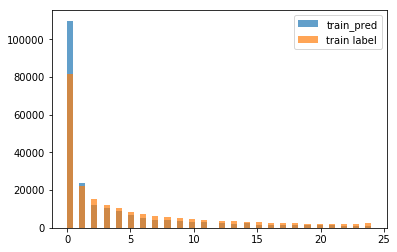

In [70]:
_ = plt.hist(trn_pred_label, bins=50, label='train_pred', alpha=0.7)
_ = plt.hist(y_trn, bins=50, label = 'train label', alpha=0.7)
_ = plt.legend()

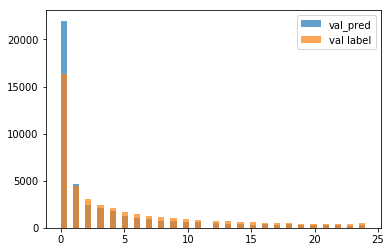

In [71]:
_ = plt.hist(val_pred_label, bins=50, label='val_pred', alpha=0.7)
_ = plt.hist(y_val, bins=50, label = 'val label', alpha=0.7)
_ = plt.legend()

In [72]:
# train mrr: 0.47 | val mrr: 0.45

In [73]:
# add mrr at per epochs probably
# look at no embeddings

In [74]:
def confusion_matrix(y_pred, y_true, normalize='row', level=0, log_scale=False):
    compare = pd.DataFrame({'prediction': y_pred, 'y_true': y_true})
    counts = compare.groupby('y_true')['prediction'].value_counts()
    mat = counts.unstack(level=0)
    mat.fillna(0, inplace=True)
    
    if normalize == 'row':
        row_sum = mat.sum(axis=1)
        mat = mat.div(row_sum, axis=0)
        log_scale = False
    elif normalize == 'column':
        col_sum = mat.sum(axis=0)
        mat = mat.div(col_sum, axis=1)
        log_scale = False
    # plot
    fig = plt.figure(figsize=(35,10))
    ax = fig.add_subplot(111)
    if log_scale:
        cax = ax.matshow(np.log1p(mat), interpolation='nearest')#, cmap='coolwarm')#, aspect='auto')
    else:
        cax = ax.matshow(mat, interpolation='nearest')#, cmap='coolwarm')#, aspect='auto')
    fig.colorbar(cax)
    ax.set_xlabel(f'{mat.columns.name}')
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel(f'{mat.index.name}')
    
    ax.set_xticks(np.arange(mat.shape[1]))
    ax.set_xticklabels(list(mat.columns.astype(str)), rotation=90)
    ax.set_yticks(np.arange(mat.shape[0]))
    _ = ax.set_yticklabels(list(mat.index.astype(str)))
    return mat

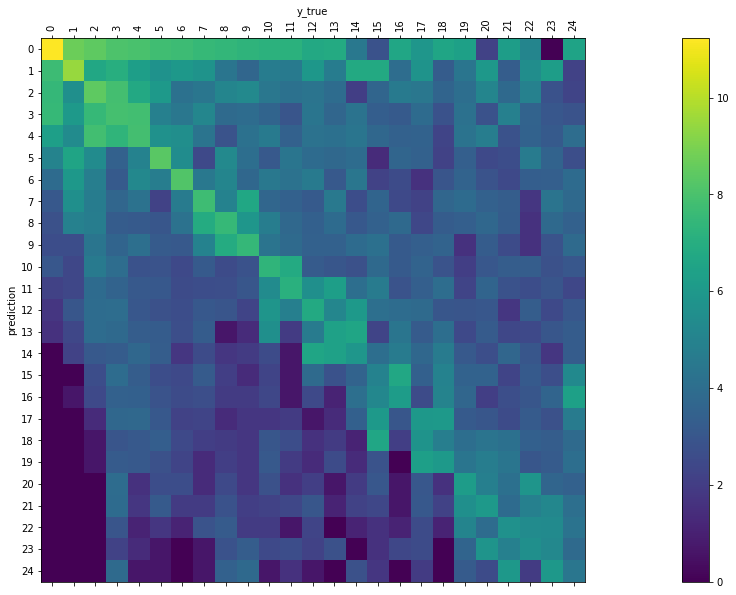

In [75]:
mat = confusion_matrix(trn_pred_label, y_trn, normalize=False, level=0, log_scale=True)


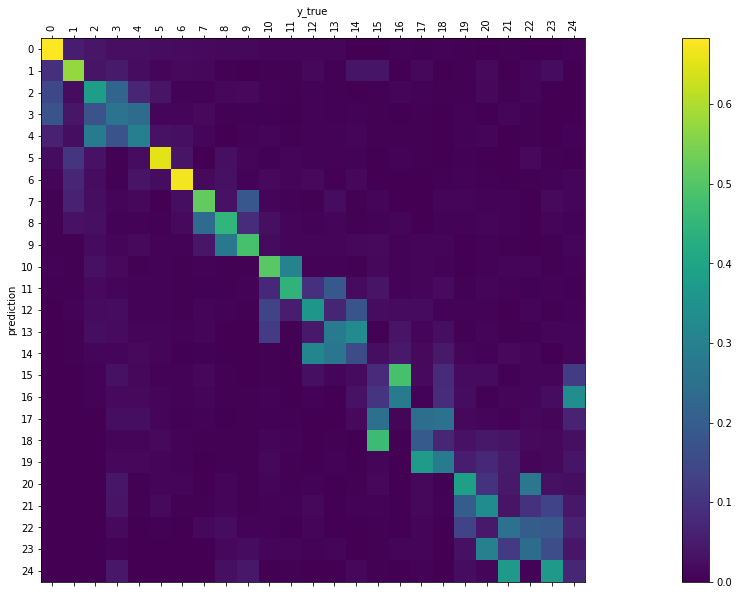

In [76]:
mat = confusion_matrix(trn_pred_label, y_trn, normalize='row')


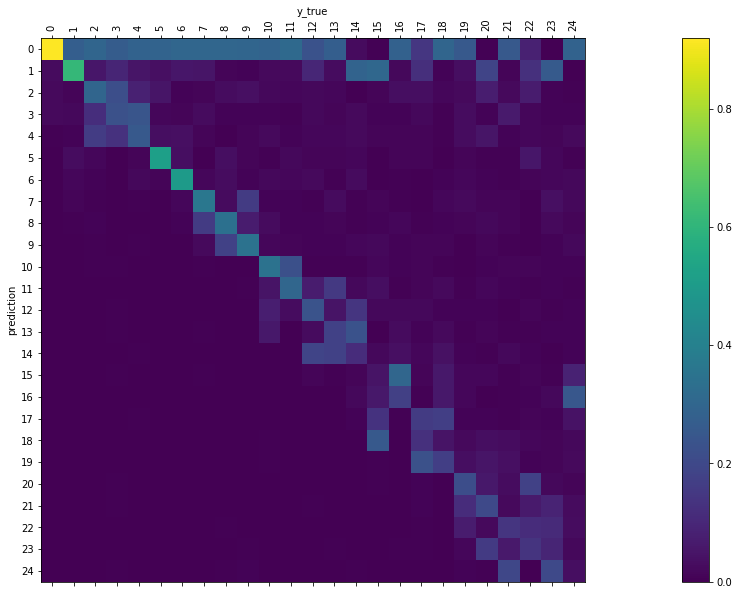

In [77]:
mat = confusion_matrix(trn_pred_label, y_trn, normalize='column')

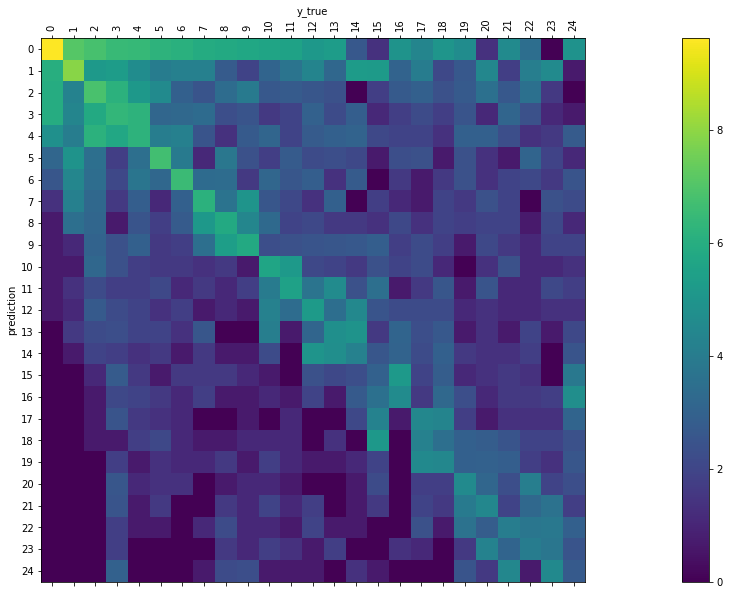

In [78]:
mat = confusion_matrix(val_pred_label, y_val, level=0, normalize=None, log_scale=True)